In [2]:
import numpy as np
import matplotlib.pyplot as plt
import LSE_net
import torch
import importlib
import pickle
import datetime

In [3]:
# custom log function w.r.t. a given base
def myLog(x, base):
    return np.log(x)/np.log(base)

# create a beta array using geometric progression
def createBetaArray(min, max, grow):
    beta = min
    beta_array = [beta]
    while beta <= max:
        beta = beta*grow
        beta_array.append(beta)
    beta_array = np.array(beta_array)
    return beta_array

# compute log sum exponential function for a given D and beta
def logSumExp(D_array, beta):
    D_min = np.min(D_array)
    D_off = D_array - D_min
    F = -1/beta * np.log(np.sum(np.exp(-beta*D_off))) + 1/beta * np.log(len(D_array)) + D_min
    # F = -np.log(np.sum(np.exp(-beta*D_off))) + np.log(len(D_array)) + D_min * beta
    return F

# compute log sum exponential function for a given D and beta
def sumExp(D_array, beta):
    return np.sum(np.exp(-beta * D_array))

# compute gibbs distribution over a D array
def gibbs(D_array, beta):
    D_min = np.min(D_array)
    D_off = D_array - D_min
    exp_bD = np.exp(-beta * D_off)
    sum_exp_bD = np.sum(exp_bD)
    P = exp_bD/sum_exp_bD
    return P

# function to approximate LSE via area method
def area_approx_F(D_min, D_max_range, N_D, beta):
    min_beta_D_arr = beta * D_min
    x_max = beta * D_max_range - min_beta_D_arr
    F_est = -1/beta * np.log(N_D/x_max * (1 - np.exp(-x_max))) + D_min + 1/beta * np.log(N_D)
    return F_est


# function to generate LSE dataset
def LSE_data_at_beta(b_min, b_max, b_grow, D_array, io_scale):
    b_array = createBetaArray(b_min, b_max, b_grow)
    n_beta_per_curve = len(b_array)
    n_data = n_beta_per_curve
    In = torch.zeros((n_data, 1), dtype=torch.float32)
    Out = torch.zeros((n_data,1), dtype=torch.float32)

    cnt = 0
    for b in b_array:
        Fb = io_scale * logSumExp(D_array, b)
        In[cnt,:] = torch.tensor([b])
        Out[cnt,:] = torch.tensor([Fb])
        cnt += 1

    return In, Out, b_array


# function to generate LSE dataset
def data_single_paths(n_curves, b_min, b_max, b_grow, D_min_range, D_max_scale, len_Darray_range, approx_log_sum_flr, io_scale):
    b_array = createBetaArray(b_min, b_max, b_grow)
    n_beta_per_curve = len(b_array)
    n_data = n_curves * n_beta_per_curve
    In = torch.zeros((n_data, 3), dtype=torch.float32)
    Out = torch.zeros((n_data,1), dtype=torch.float32)
    len_D_ARR = []

    cnt = 0
    for c in range(n_curves):
        
        len_Darray = int(np.random.uniform(len_Darray_range[0], len_Darray_range[1]))
        D0 = np.random.uniform(D_min_range[0], D_min_range[1])
        D_array = np.random.uniform(D0, D_max_scale, len_Darray)
        D_min = np.min(D_array)
        if approx_log_sum_flr:
            F_min = area_approx_F(D_min, D_max_scale, len_Darray, b_min)
        else:
            F_min = logSumExp(D_array, b_min)
        F_min = io_scale * F_min
        F_max = io_scale * D_min

        for b in b_array:
            Fb = io_scale * logSumExp(D_array, b)
            # In[cnt,:] = torch.tensor([F_min, F_max, myLog(b,10)])
            In[cnt,:] = torch.tensor([F_min, myLog(b,10)])
            Out[cnt,:] = torch.tensor([Fb])
            len_D_ARR.append(len_Darray)
            cnt += 1

    return In, Out, len_D_ARR


### Demonstrate learning for a single logSumExp curve $F_D(\beta)$, where $D$ is a given array of distance values

In [4]:
D_min = 10.0
D_max_scale = 1000.0
N_D = 100
D_array0 = np.random.uniform(D_min, D_max_scale, N_D)
# D_array0 = D_array0 - np.min(D_array0)

b_min = 1e-2
b_max = 1e1
b_grow = 1.005
In_b, Out_b, b_arr0 = LSE_data_at_beta(b_min, b_max, b_grow, D_array0, io_scale=1)
print(f'In:\t{In_b.size()}\nOut:\t{Out_b.size()}')

In:	torch.Size([1387, 1])
Out:	torch.Size([1387, 1])


In [38]:
In_b, Out_b, b_arr0

(tensor([[1.0000e-02],
         [1.0050e-02],
         [1.0100e-02],
         ...,
         [9.9501e+00],
         [9.9999e+00],
         [1.0050e+01]]),
 tensor([[245.1574],
         [244.4869],
         [243.8173],
         ...,
         [ 15.4021],
         [ 15.3998],
         [ 15.3975]]),
 array([1.00000000e-02, 1.00500000e-02, 1.01002500e-02, ...,
        9.95014641e+00, 9.99989714e+00, 1.00498966e+01]))

In [39]:
# E = (-np.log(np.array([sumExp(D_array0, beta) for beta in b_arr0])) + np.log(len(D_array0)))
# E

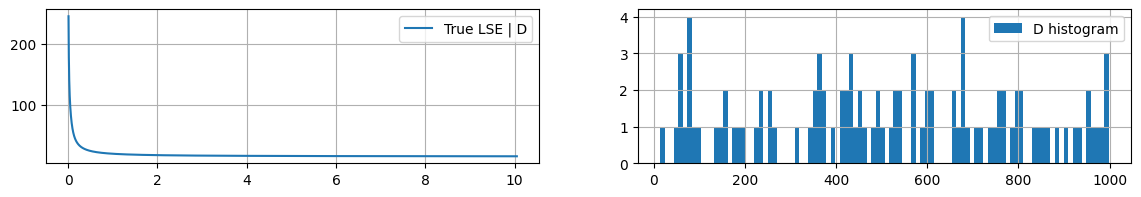

In [40]:
plt.figure(figsize=(14,2))
plt.subplot(1,2,1)
# plt.plot(myLog(In_b.numpy().flatten(),10), Out_b.numpy().flatten(), label='True LSE | D')
# plt.plot(myLog(In_b.numpy().flatten(),10), E, label='E | D')
plt.plot(In_b.numpy().flatten(), Out_b.numpy().flatten(), label='True LSE | D')
# plt.plot(In_b.numpy().flatten(), E, label='E | D')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.hist(D_array0, bins=100, label='D histogram')
plt.grid()
plt.legend()

plt.show()

In [41]:
importlib.reload(LSE_net)

# create DNN
n_inputs = In_b.size()[1]
n_outputs = Out_b.size()[1]
layers = [20, 10, 5]
LSE_beta_net = LSE_net.dnn(n_inputs, n_outputs, layers)
print(f'LSE_beta model:\n{LSE_beta_net}')

# create training, and testing dataset
n_samples = In_b.size()[0]
frac_train = 0.99
n_train = int(frac_train * n_samples)
indices = torch.arange(n_samples)
train_indices = indices[:n_train]
test_indices = indices[n_train:]
In_train = In_b[train_indices]
Out_train = Out_b[train_indices]
In_test = In_b[test_indices]
Out_test = Out_b[test_indices]


LSE_beta model:
dnn(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=1, bias=True)
  )
)


In [42]:
In_train, Out_train

(tensor([[0.0100],
         [0.0100],
         [0.0101],
         ...,
         [9.2791],
         [9.3255],
         [9.3721]]),
 tensor([[245.1574],
         [244.4869],
         [243.8173],
         ...,
         [ 15.4355],
         [ 15.4331],
         [ 15.4306]]))

In [43]:
LSE_beta_net(In_train[0])

tensor([-0.0037], grad_fn=<ViewBackward0>)

In [44]:
# dnn configuration
optimizer_name = 'adam'
lr_scheduler = 'ReduceLROnPlateau'
lr0 = 0.0002
epochs = 2000
batch_size = 50
loss_coeffs = [1.0, 0.0]
loss_fn, optimizer, scheduler = LSE_net.config_nn(LSE_beta_net, optimizer_name, lr_scheduler, lr0)
loss = loss_fn(LSE_beta_net(In_train[0]), Out_train[0]).detach().item()
training_loss, learning_rate, stopping_epoch = LSE_net.train_nn1(
    LSE_beta_net, In_train, Out_train, loss_fn,
    optimizer, scheduler, loss_coeffs=loss_coeffs,
    epochs=epochs, batch_size=batch_size, shuffledata=False, allowPrint=True)



---------------------------------
training data size = 1373
training batch size = 50
n_epochs = 2000
n_batches = 28
loss weights = [1.0, 0.0]
---------------------------------

batch_split
0 49
50 99
100 149
150 199
200 249
250 299
300 349
350 399
400 449
450 499
500 549
550 599
600 649
650 699
700 749
750 799
800 849
850 899
900 949
950 999
1000 1049
1050 1099
1100 1149
1150 1199
1200 1249
1250 1299
1300 1349
1350 1372



---------------------------------
epoch: 0/2000, 	 loss: 5645.218 	 rel:1.000e+03, 	 time: 0.02
epoch: 1/2000, 	 loss: 5645.218 	 rel:1.000e+03, 	 time: 0.02
epoch: 2/2000, 	 loss: 5639.065 	 rel:9.989e+02, 	 time: 0.02
epoch: 3/2000, 	 loss: 5633.729 	 rel:9.980e+02, 	 time: 0.02
epoch: 4/2000, 	 loss: 5628.768 	 rel:9.971e+02, 	 time: 0.02
epoch: 5/2000, 	 loss: 5624.022 	 rel:9.962e+02, 	 time: 0.02
epoch: 6/2000, 	 loss: 5619.422 	 rel:9.954e+02, 	 time: 0.05
epoch: 7/2000, 	 loss: 5615.566 	 rel:9.947e+02, 	 time: 0.02
epoch: 8/2000, 	 loss: 5611.880 	 rel:9.94

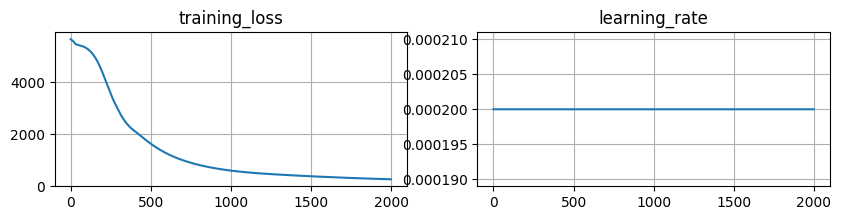

In [45]:
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.plot(training_loss)
plt.title('training_loss')
plt.grid()
plt.subplot(1,2,2)
plt.plot(learning_rate)
plt.title('learning_rate')
plt.grid()

plt.show()


In [46]:
b_min_v = 1e-2
b_max_v = 10
b_grow_v = 1.001
In_bv, Out_bv, b_arrv0 = LSE_data_at_beta(b_min_v, b_max_v, b_grow_v, D_array0, io_scale=1)

Pred_bv = LSE_beta_net(In_bv)
loss_bv = loss_fn(Pred_bv, Out_bv).detach().item()
print(f"validation loss:{loss_bv}")


validation loss:295.6772155761719


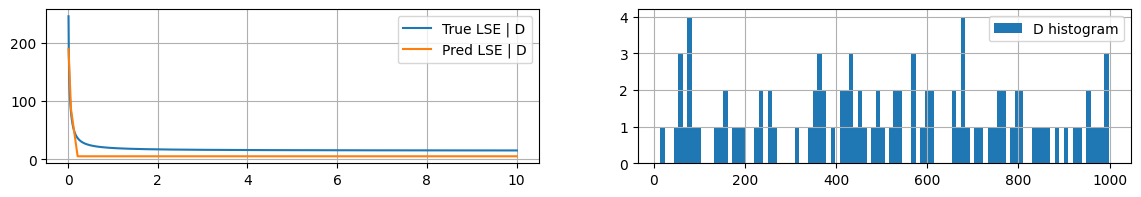

In [47]:
plt.figure(figsize=(14,2))
plt.subplot(1,2,1)
plt.plot(In_bv.numpy().flatten(), Out_bv.numpy().flatten(), label='True LSE | D')
plt.plot(In_bv.numpy().flatten(), Pred_bv.detach().numpy().flatten(), label='Pred LSE | D')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.hist(D_array0, bins=100, label='D histogram')
plt.grid()
plt.legend()

plt.show()